In [1]:
from torch.utils.data import DataLoader

In [2]:
import os
import wandb
import numpy as np
from IPython.display import clear_output
import seaborn as sns
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jagpreetjakhar94. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="NODE_rnn", group="NODE_rnn",save_code=True,notes="Neural ODE RNN runs and evaluation")

In [30]:
def visualize(real=None, train=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.set_title('Lorenz Attractor \n'+title)

    if train is not None:
      sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in train])
      z = np.reshape(z, [-1,3])
      sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
      #cbar = fig.colorbar(sc)

    if real is not None:
      #sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in real])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
      #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
      #cbar = fig.colorbar(sc)
      #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()

In [16]:
def lorenz(t, X):
    sigma = 10.
    beta = 8/3
    rho = 28.
    if X.ndim == 1:
        x, y, z = X
    else:
        x, y, z = X.unbind(dim=-1)
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return torch.stack([xdot, ydot, zdot], dim=-1)

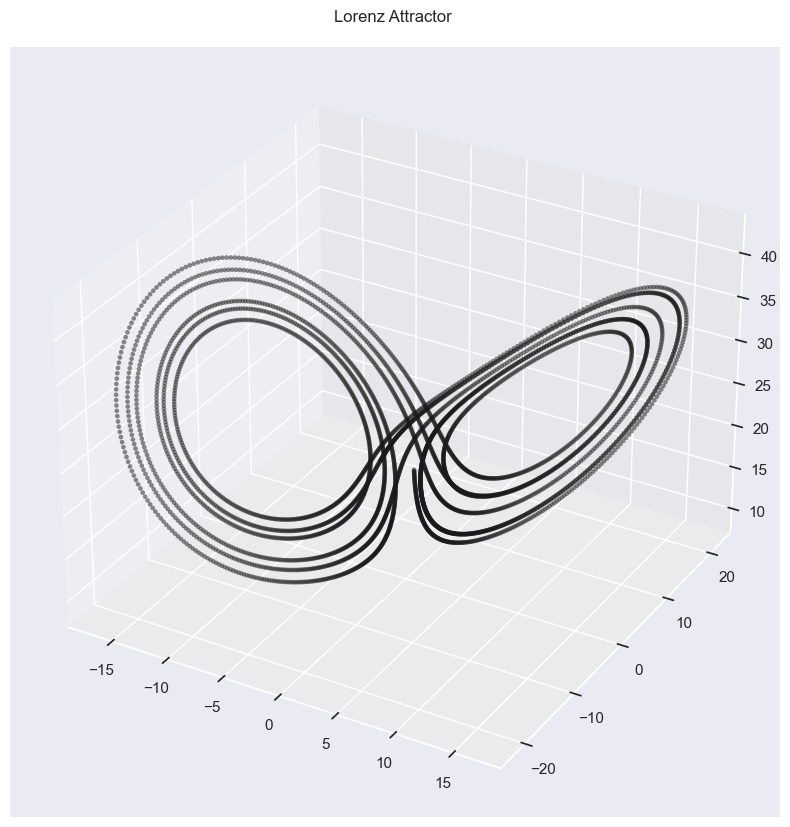

In [49]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[0.5, 0.5, 20.]])  # initial condition
t = torch.linspace(0., 10., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)

visualize(real=data)

In [50]:
data.shape

torch.Size([5000, 1, 3])

In [11]:
wandb_config = {
    'hidden_size': 512,
    'learning_rate': 1e-2,
    'batch_size': 50,
    'max_iterations': 1000,
}

# Initialize wandb configuration
wandb.config.update(wandb_config)

In [10]:
#sweep_id = wandb.sweep(sweep_path="sweep.yaml", project="NODE_rnn")

In [52]:
class LorenzTrain(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(LorenzTrain, self).__init__()
        self.lin = nn.Linear(3, 512)
        self.lin3 = nn.Linear(512, 3)
        self.relu = nn.ReLU()

    def forward(self, t, x):
        x = self.relu(self.lin(x))
        x = self.lin3(x)
        return x
     

In [9]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = t[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0, batch_t, batch_y

In [10]:
np.random.seed(7)

In [15]:

func = LorenzTrain().to(device)  # initializing Neural ODE
visualizer = visualize
optimizer = optim.Adam(func.parameters(), lr=1e-2)

In [53]:
data = data.to(device)

In [54]:
t = t.to(device)

In [17]:
#os.makedirs("PNG")

In [56]:
data[0]

tensor([[ 0.5000,  0.5000, 20.0000]], device='cuda:0')

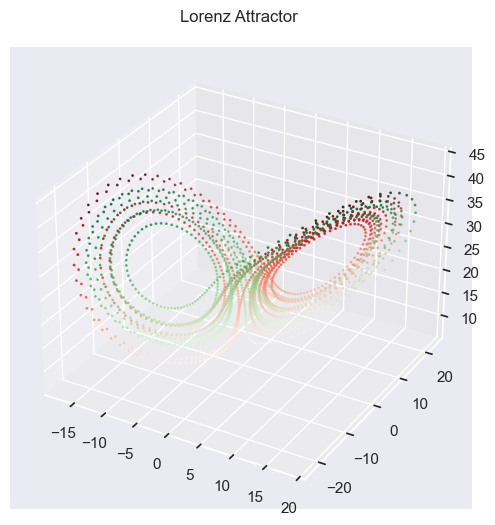

Iter 3000 | Total Loss 76.988525


In [19]:
losses = []
whole_losses = []
best_loss = 1.0
for itr in range(1, 3000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(data,50)  # getting trajectory batch
    pred_y = odeint(func, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(func.state_dict(), 'saved_models/lorenz_node.pth')
    if itr % 40 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(func, data[0], t)
            loss = F.mse_loss(pred_y, data)
            whole_losses.append(loss.item())
            visualize(real=data.cpu(), 
                             train=pred_y.cpu())

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)


In [20]:
t_s = torch.linspace(0., 10., 1000)

In [21]:
t_s.shape

torch.Size([1000])

In [22]:
t.shape

torch.Size([1000])

In [23]:
data[0]

tensor([[-8.,  7., 27.]], device='cuda:0')

In [24]:
input_seq = data[0]

In [57]:
test_model = LorenzTrain().to(device)

In [58]:
test_model.load_state_dict(torch.load('saved_models\lorenz_node.pth'))

<All keys matched successfully>

In [59]:
# Generate a more accurate simulation using the learned dynamics
num_trajectories = 1  # Number of trajectories to simulate
trajectories = []
with torch.no_grad():
    
        # Sample a random initial point from the attractor
       

        # Propagate the initial point forward in time
    predicted_trajectory = odeint(test_model, data[0].to(device), t)
    trajectories.append(predicted_trajectory.cpu().numpy())
    
# Convert the tensors to NumPy arrays for plotting
trajectories_np = np.array(trajectories)



In [60]:
trajectories_np.shape

(1, 5000, 1, 3)

In [61]:
data.shape

torch.Size([5000, 1, 3])

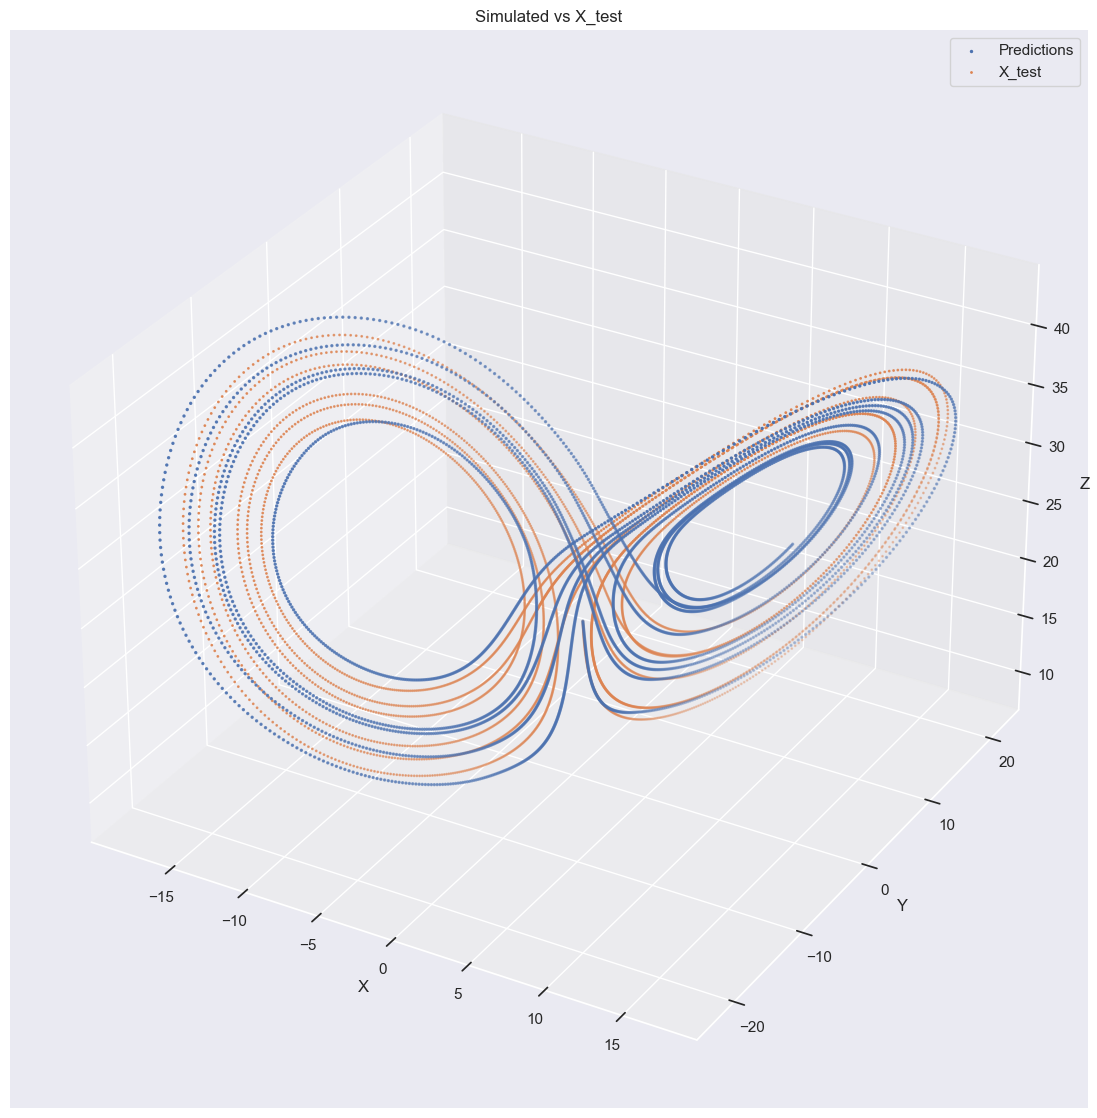

In [62]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = trajectories_np[:,:, :, 0]
y_pred = trajectories_np[:,:, :, 1]
z_pred = trajectories_np[:,:, :, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = data[0:, :, 0].cpu()
y_train = data[ 0:, :, 1].cpu()
z_train = data[ 0:, :, 2].cpu()

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()



In [63]:
x_pred[0,:,0].shape

(5000,)

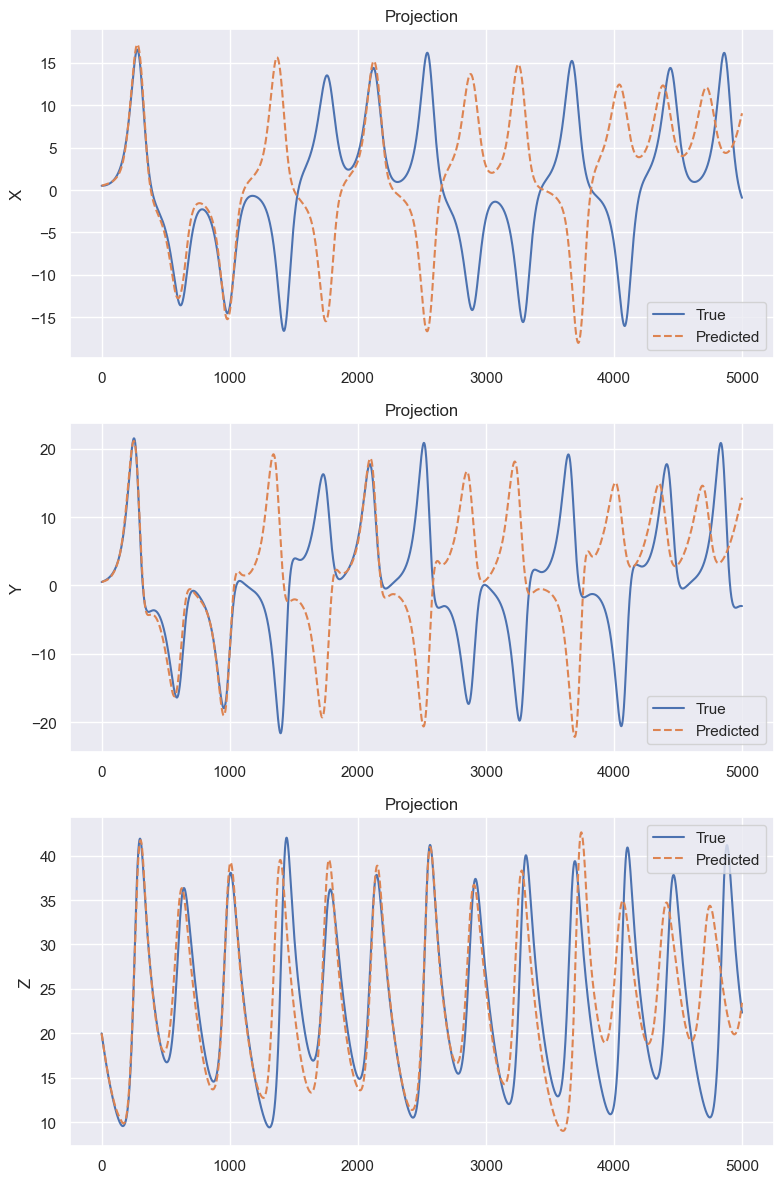

In [64]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred[0,:,0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 30)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred[0,:,0], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred[0,:,0], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

In [35]:
t_s = torch.linspace(0, 20, 2000)

In [36]:
t_s.shape

torch.Size([2000])

In [38]:
# Generate a more accurate simulation using the learned dynamics
num_trajectories = 1  # Number of trajectories to simulate
trajectories = []
with torch.no_grad():
    
        # Sample a random initial point from the attractor
       

        # Propagate the initial point forward in time
    predicted_trajectory = odeint(func, torch.tensor([[-8., 7., 27.]]).to(device), t_s)
    trajectories.append(predicted_trajectory.cpu().numpy())
    
# Convert the tensors to NumPy arrays for plotting
trajectories_np_extend = np.array(trajectories)



d:\work\work\lib\site-packages\torchdiffeq\_impl\misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [39]:
trajectories_np_extend.shape

(1, 2000, 1, 3)

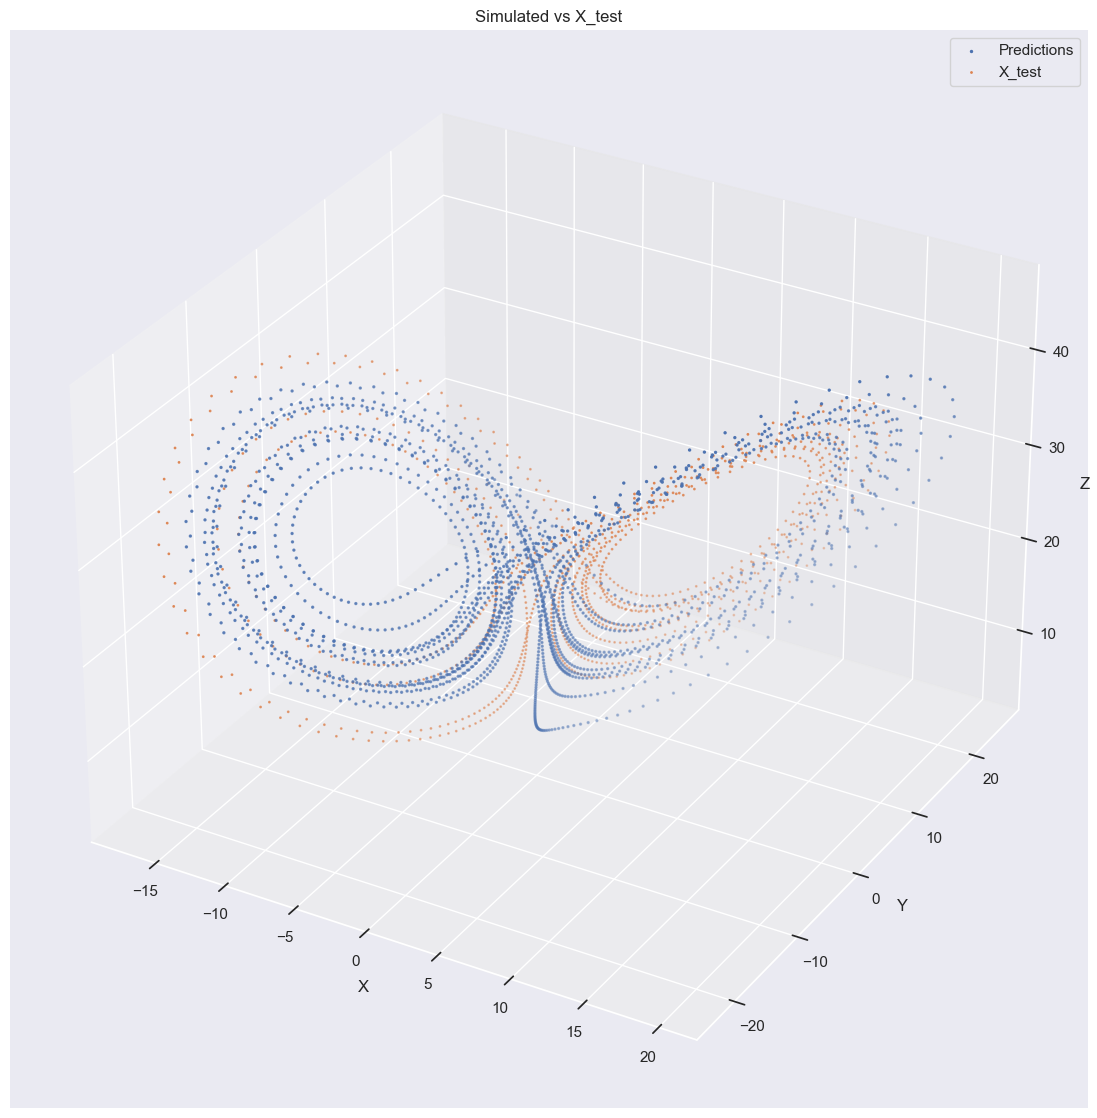

In [41]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = trajectories_np_extend[:, :, :, 0]
y_pred = trajectories_np_extend[:, :, :, 1]
z_pred = trajectories_np_extend[:, :, :, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = data[0:, :, 0].cpu()
y_train = data[ 0:, :, 1].cpu()
z_train = data[ 0:, :, 2].cpu()

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()



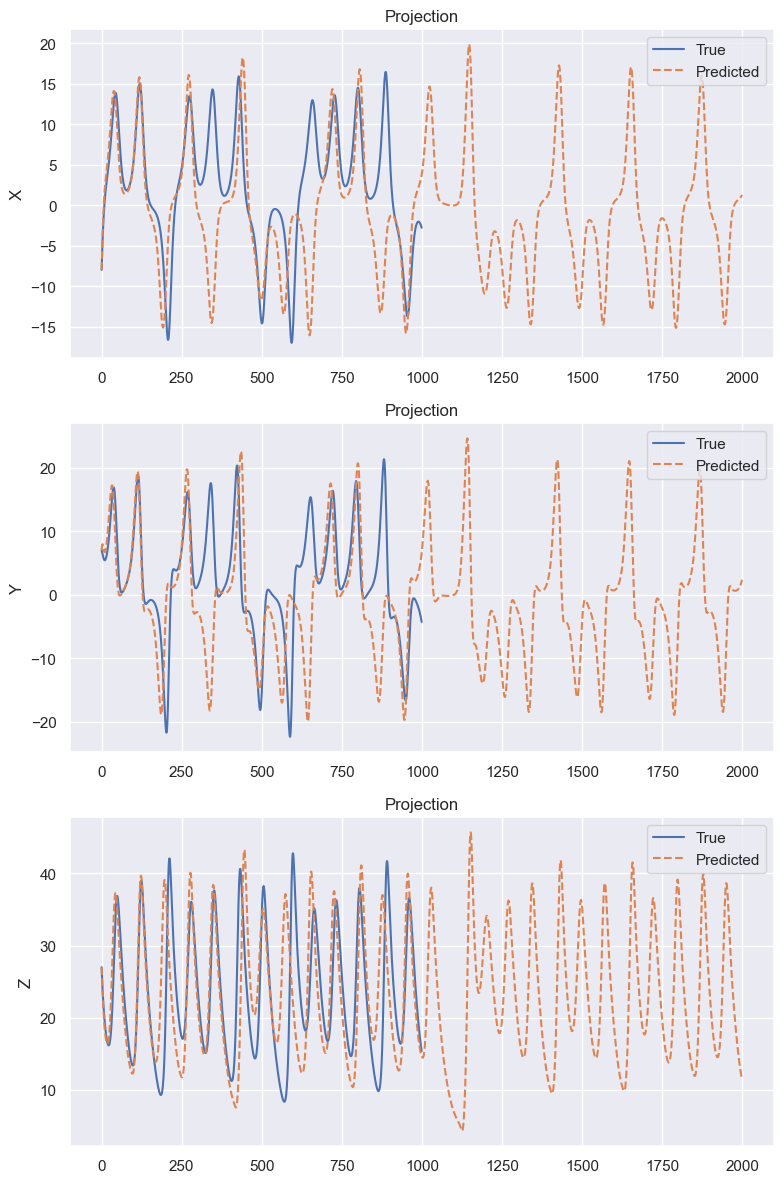

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred[0,:,0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 30)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred[0,:,0], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred[0,:,0], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

In [35]:
func_chunks = LorenzTrain()  # initializing Neural ODE
visualizer = visualize_3d
optimizer = optim.Adam(func_chunks.parameters(), lr=1e-2)

In [36]:
import random
start_index = random.randint(0, len(train_data) - 100)
    
    # Get a random continuous chunk of size 100 from train_data
chunk = train_data[start_index : start_index + 100]

In [37]:
batch_y0, batch_t, batch_y = get_batch(chunk, 50)

In [38]:
batch_y0.shape, batch_t.shape, batch_y.shape

(torch.Size([50, 1, 3]), torch.Size([50]), torch.Size([50, 50, 1, 3]))

In [39]:
batch_y0[-1]

tensor([[11.9194, 16.1514, 26.0805]])

In [40]:
batch_y[0][-1]

tensor([[11.9194, 16.1514, 26.0805]])

In [41]:
start_indices = random.sample(range(len(train_data) - 100), 900)

In [42]:
a = range(len(train_data) - 100)

In [43]:
len(start_indices)

900

In [44]:
import random

for itr in range(1, 3000 + 1):
    optimizer.zero_grad()
    
    # Generate random start index for the chunk
    start_index = random.randint(0, len(train_data) - 100)
    
    # Get a random continuous chunk of size 100 from train_data
    chunk = train_data[start_index : start_index + 100]
    
    batch_y0, batch_t, batch_y = get_batch(chunk, 40)  # getting trajectory batch
    pred_y = odeint(func_chunks, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    if itr % 150 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(func_chunks, train_data[0], t)
            loss = F.mse_loss(pred_y, train_data)

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            #clear_output(wait=True)

Iter 0150 | Total Loss 88.993050
Iter 0300 | Total Loss 112.037354
Iter 0450 | Total Loss 108.526352
Iter 0600 | Total Loss 148.780838
Iter 0750 | Total Loss 106.917435
Iter 0900 | Total Loss 123.685295
Iter 1050 | Total Loss 172.361435
Iter 1200 | Total Loss 125.331230
Iter 1350 | Total Loss 141.242569
Iter 1500 | Total Loss 185.038834
Iter 1650 | Total Loss 157.378891
Iter 1800 | Total Loss 141.622559
Iter 1950 | Total Loss 137.785736
Iter 2100 | Total Loss 132.464264
Iter 2250 | Total Loss 141.450378
Iter 2400 | Total Loss 101.358208
Iter 2550 | Total Loss 170.920441
Iter 2700 | Total Loss 158.190826
Iter 2850 | Total Loss 140.401581
Iter 3000 | Total Loss 148.959183


In [45]:
# Generate a more accurate simulation using the learned dynamics
num_trajectories = 1  # Number of trajectories to simulate
trajectories = []
with torch.no_grad():
    
        # Sample a random initial point from the attractor
       

        # Propagate the initial point forward in time
    predicted_trajectory = odeint(func_chunks, torch.tensor([[-8., 7., 27.]]), t_s)
    trajectories.append(predicted_trajectory.cpu().numpy())
    
# Convert the tensors to NumPy arrays for plotting
trajectories_np_extend = np.array(trajectories)



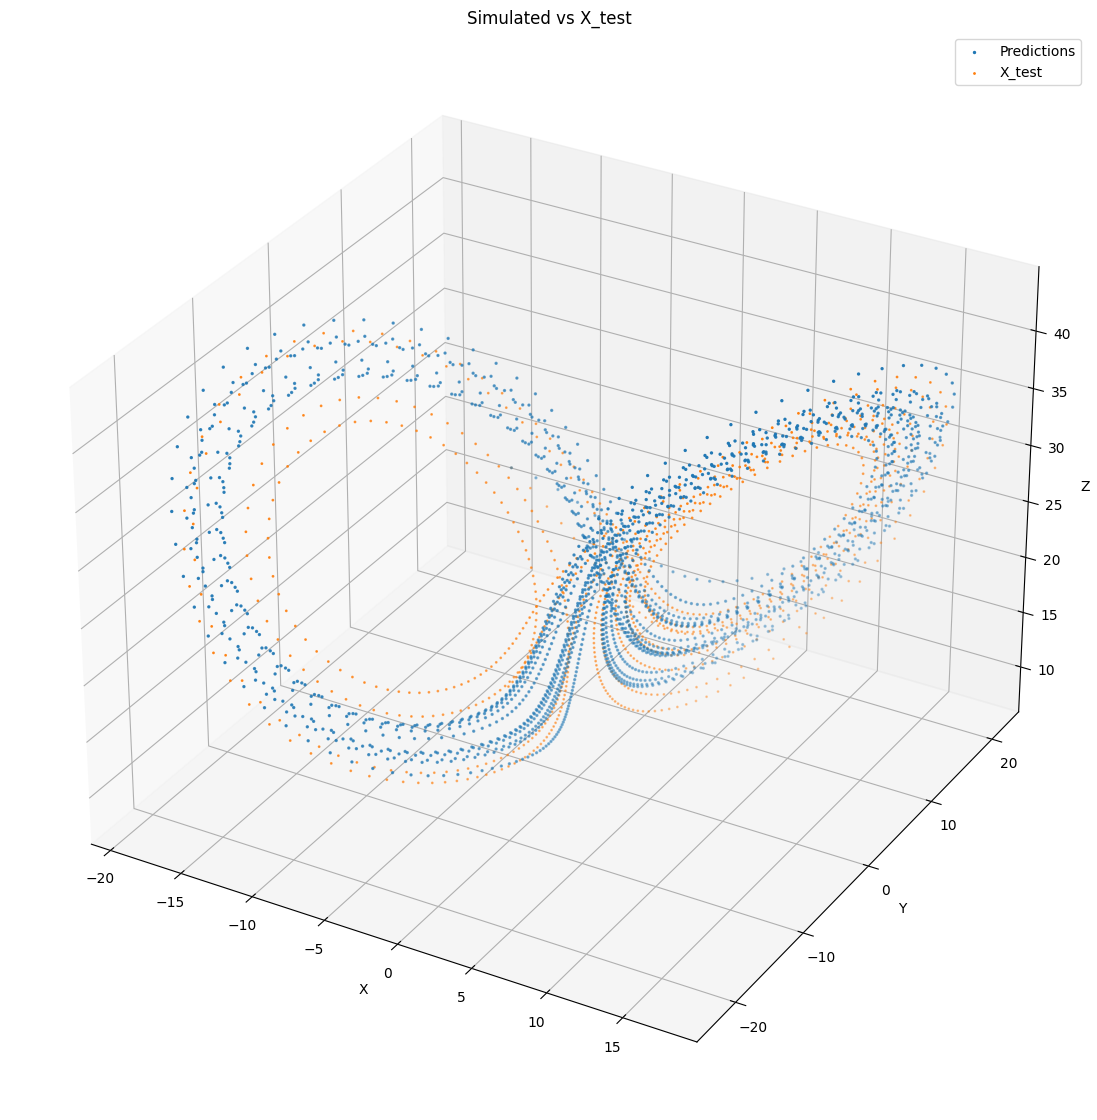

In [46]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = trajectories_np_extend[:, 0:, :, 0]
y_pred = trajectories_np_extend[:, 0:, :, 1]
z_pred = trajectories_np_extend[:, 0:, :, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train_data[0:, :, 0]
y_train = train_data[ 0:, :, 1]
z_train = train_data[ 0:, :, 2]

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()



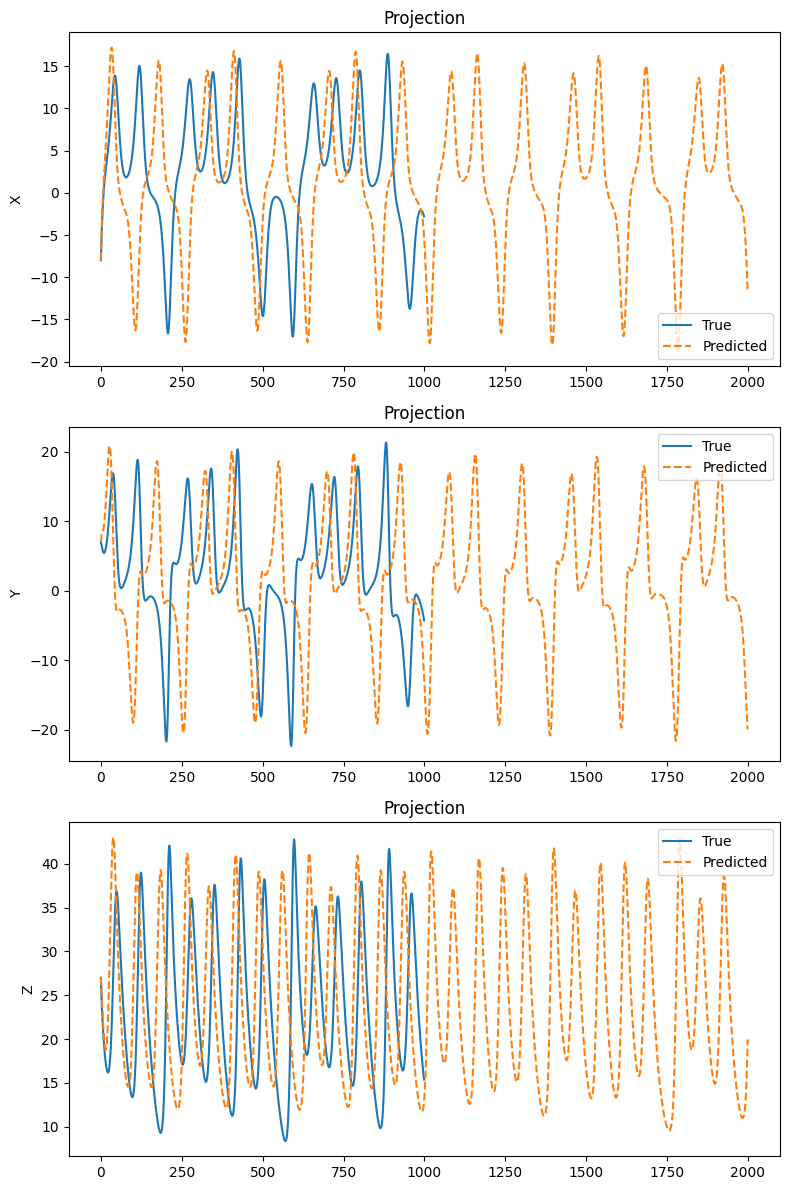

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred[0,:,0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 30)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred[0,:,0], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred[0,:,0], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

In [48]:
true_lorenz.shape

torch.Size([1000, 1, 3])

In [49]:
right_lorenz = true_lorenz[true_lorenz[:, 0, 0] > 0].clone()

In [50]:
right_lorenz.shape

torch.Size([663, 1, 3])

In [51]:
left_lorenz = true_lorenz[true_lorenz[:, 0, 0] < 0].clone()

In [52]:
left_lorenz.shape

torch.Size([337, 1, 3])

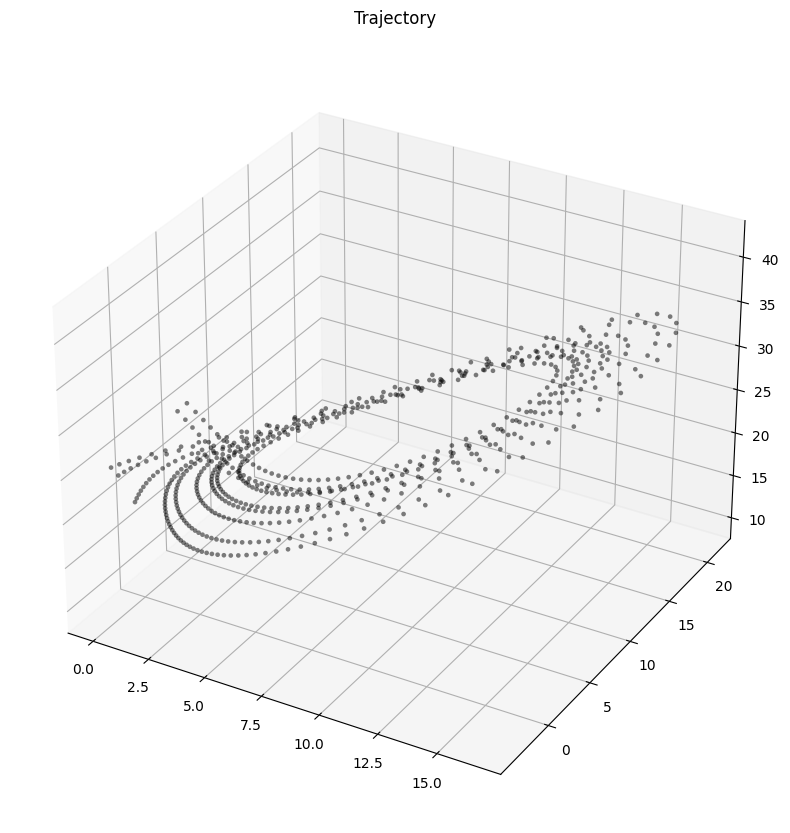

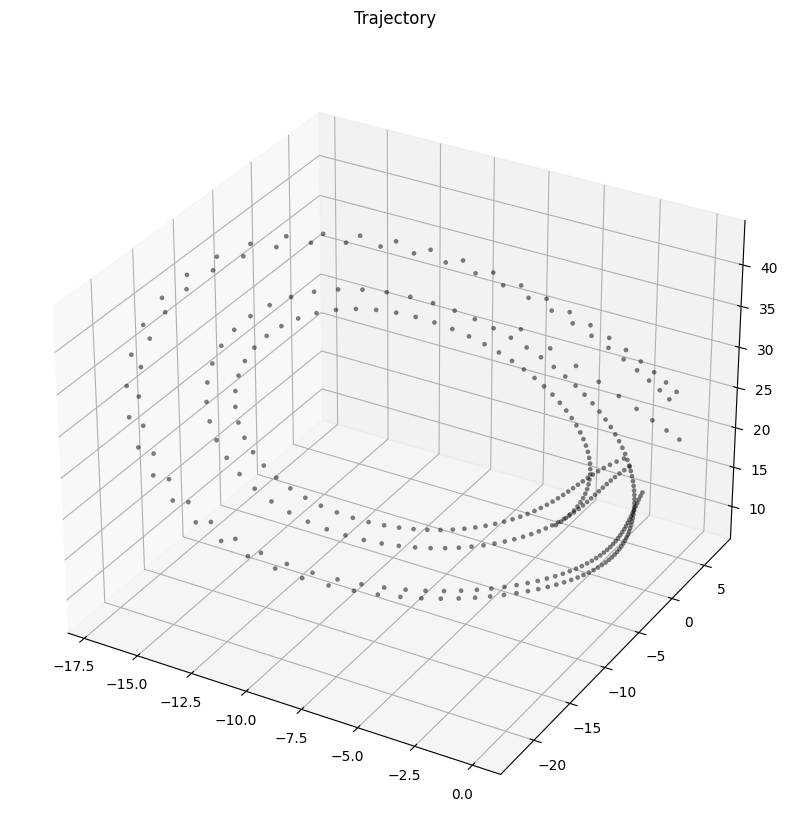

In [53]:
visualize_3d(obs=right_lorenz)
visualize_3d(obs=left_lorenz)

In [54]:
func_part = LorenzTrain()  # initializing Neural ODE
visualizer = visualize_3d
optimizer = optim.Adam(func_part.parameters(), lr=1e-2)

In [55]:
train_data = right_lorenz

In [56]:
right_lorenz.shape

torch.Size([663, 1, 3])

In [57]:
train_data.shape

torch.Size([663, 1, 3])

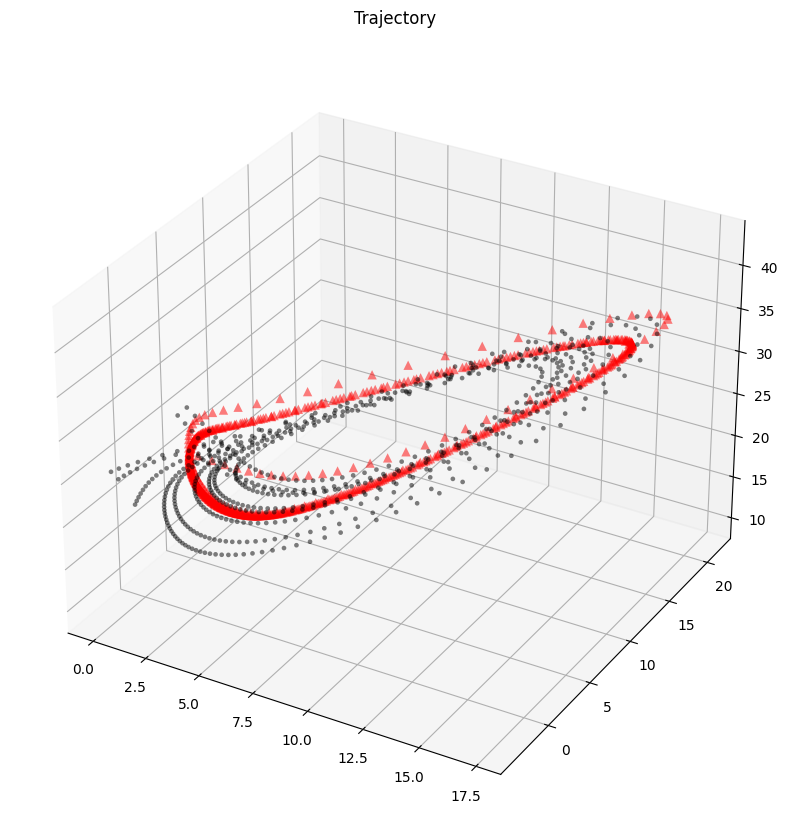

Iter 1000 | Total Loss 79.777702


In [58]:
for itr in range(1, 1000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(train_data,50)  # getting trajectory batch
    pred_y = odeint(func_part, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    if itr % 40 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(func_part, train_data[0], t[:663])
            loss = F.mse_loss(pred_y, train_data)
            save_name = "PNG/"+str(itr)
            
            visualize_3d(obs=train_data, 
                             trajs=pred_y,
                             save=save_name)

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)


In [59]:
# Generate a more accurate simulation using the learned dynamics
num_trajectories = 1  # Number of trajectories to simulate
trajectories = []
with torch.no_grad():
    
        # Sample a random initial point from the attractor
       

        # Propagate the initial point forward in time
    predicted_trajectory = odeint(func_part, torch.tensor([[-8., 7., 27.]]), t_s)
    trajectories.append(predicted_trajectory.cpu().numpy())
    
# Convert the tensors to NumPy arrays for plotting
trajectories_np_extend = np.array(trajectories)



In [60]:
train_data = true_lorenz

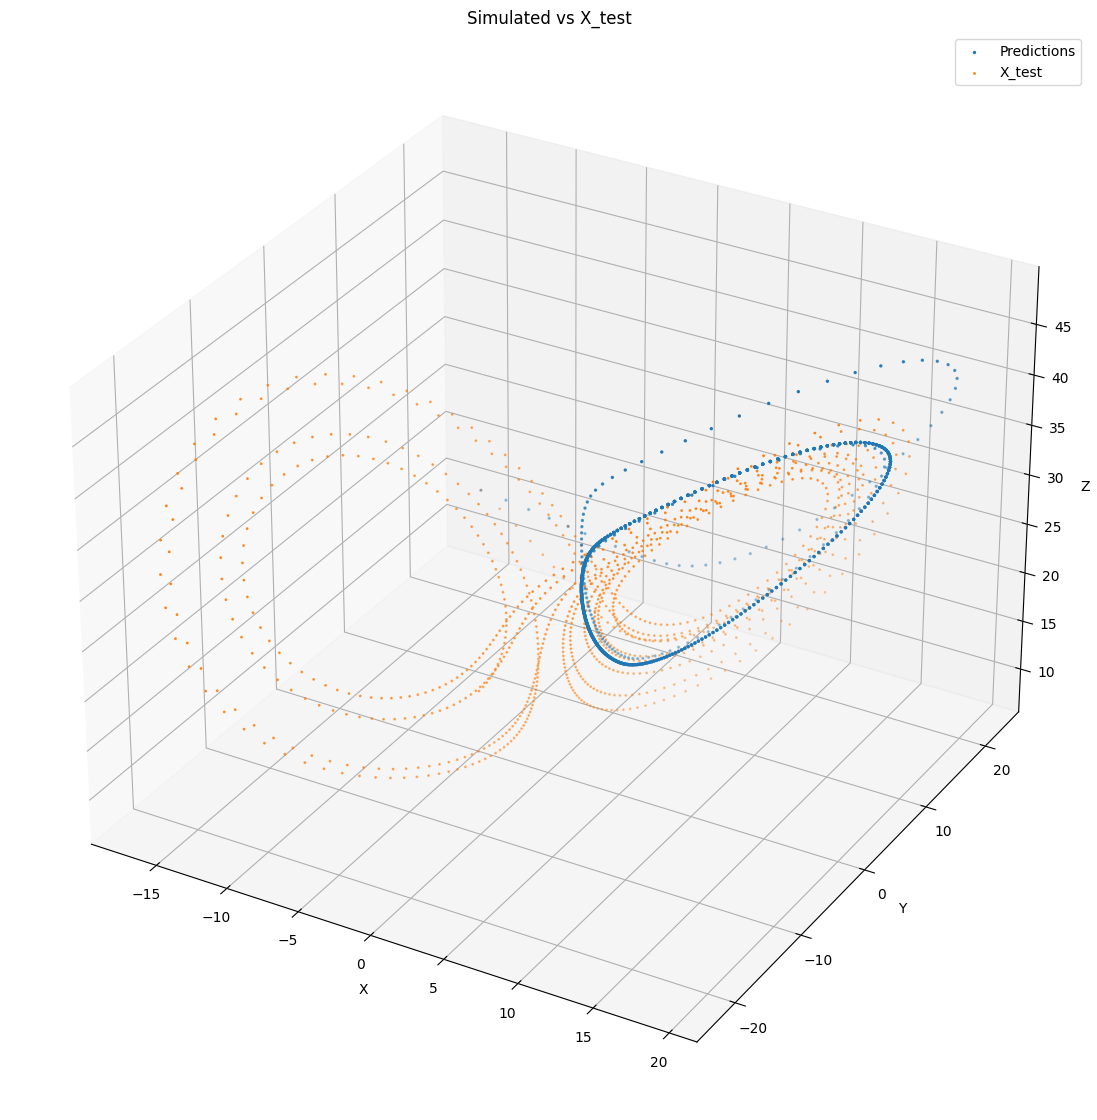

In [61]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = trajectories_np_extend[:, 0:, :, 0]
y_pred = trajectories_np_extend[:, 0:, :, 1]
z_pred = trajectories_np_extend[:, 0:, :, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train_data[0:, :, 0]
y_train = train_data[ 0:, :, 1]
z_train = train_data[ 0:, :, 2]

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()



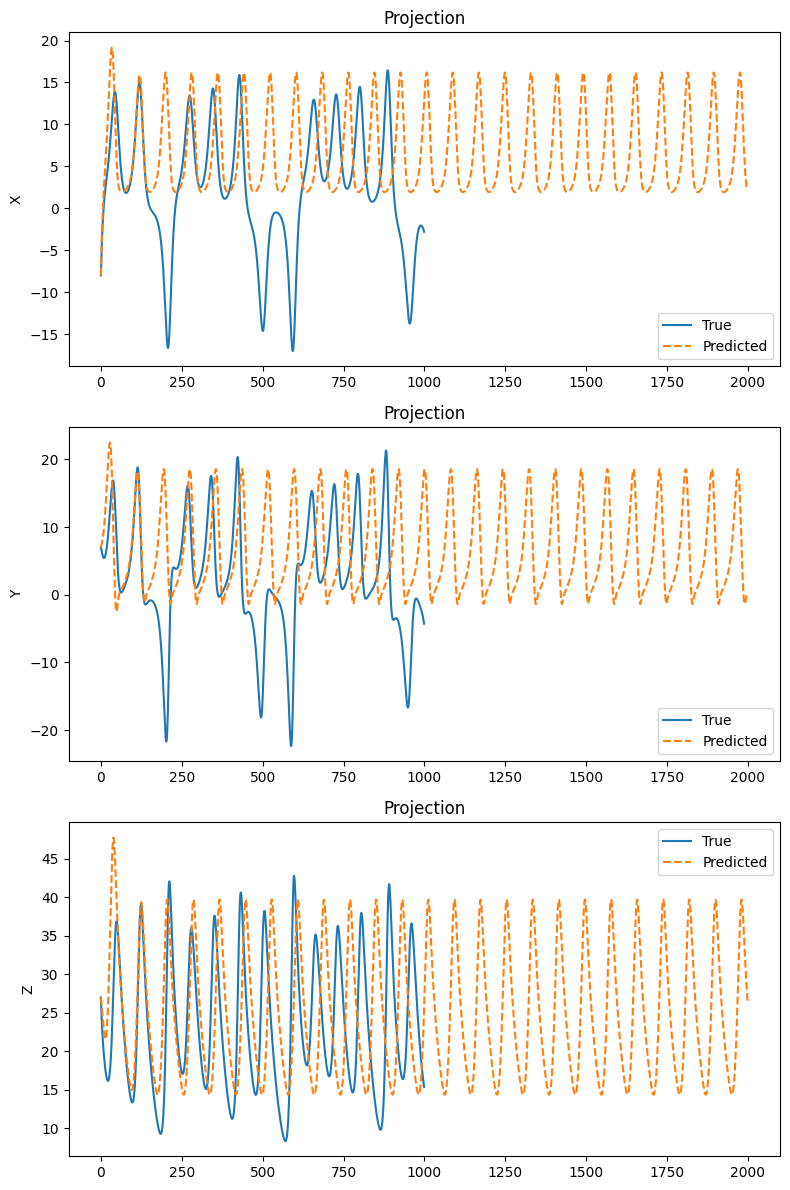

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred[0,:,0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 30)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred[0,:,0], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred[0,:,0], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

In [56]:
true_lorenz.shape

torch.Size([2000, 3])

In [319]:
t[:10]

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0501, 0.0601, 0.0701, 0.0801,
        0.0901])

In [24]:
k = train_data.size(0)

In [15]:
train_data.shape

torch.Size([2000, 3])

In [25]:
k

1000

In [26]:
# Extract the x variable from the Lorenz time series
x_vars =[]
for i in range(0, k-2, 1):
    x_t_2 = true_lorenz[i, 0]
    x_t_1 = true_lorenz[i+1,0]
    x_t_ = true_lorenz[i+2, 0]
    x_vars.append(torch.stack((x_t_2, x_t_1, x_t_)))
x_vars = torch.stack(x_vars).to(device)

In [27]:
true_lorenz[0:7]

tensor([[  1.0000,   0.0000,   0.0000],
        [ -9.4053,  -9.0816,  28.5909],
        [ -7.8939,  -8.7915,  24.9954],
        [ -8.1081,  -6.9190,  28.0646],
        [ -9.4918, -10.4267,  27.0454],
        [ -6.9785,  -7.0879,  25.0312],
        [ -9.6063,  -8.3054,  29.9260]])

In [28]:
x_vars.shape

torch.Size([998, 3])

In [29]:
x_only = LorenzTrain().to(device)  # initializing Neural ODE
visualizer = visualize_3d
optimizer = optim.Adam(x_only.parameters(), lr=1e-3)

In [39]:
pred_y = odeint(x_only, train_data[0], t)

In [40]:
train_data = true_lorenz

In [19]:
from torchdiffeq import odeint_adjoint

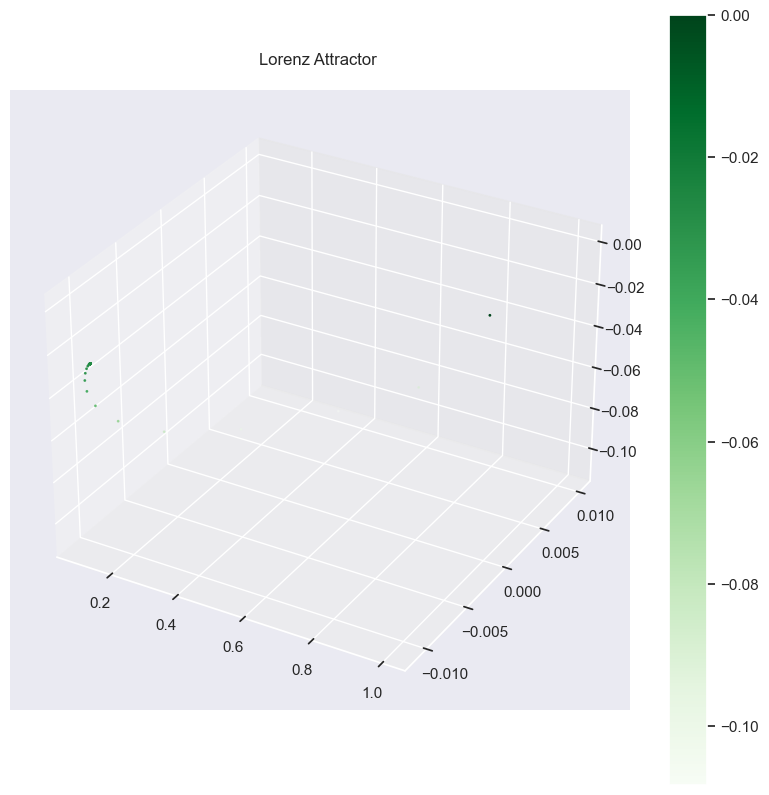

Iter 0960 | Total Loss 257.277161


In [30]:
for itr in range(1000):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(x_vars, 20)

    pred_y = odeint(x_only, batch_y0, batch_t)
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()

    if itr % 40 == 0:
        if itr > 500:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(x_only, train_data[0], t)
            loss = F.mse_loss(pred_y, train_data)
            

            visualize_3d(train=pred_y.cpu())

            # Log metrics to wandb
            wandb.log({'Iteration': itr, 'Loss': loss.item()})
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)

In [31]:
# Generate a more accurate simulation using the learned dynamics
num_trajectories = 1  # Number of trajectories to simulate
trajectories = []
with torch.no_grad():
    
        # Sample a random initial point from the attractor
       

        # Propagate the initial point forward in time
    predicted_trajectory = odeint(x_only.cpu(), torch.tensor([[-8., 7., 27.]]), t.cpu())
    trajectories.append(predicted_trajectory.cpu().numpy())
    
# Convert the tensors to NumPy arrays for plotting
trajectories_np_extend = np.array(trajectories)



In [32]:
train_data.shape

torch.Size([1000, 3])

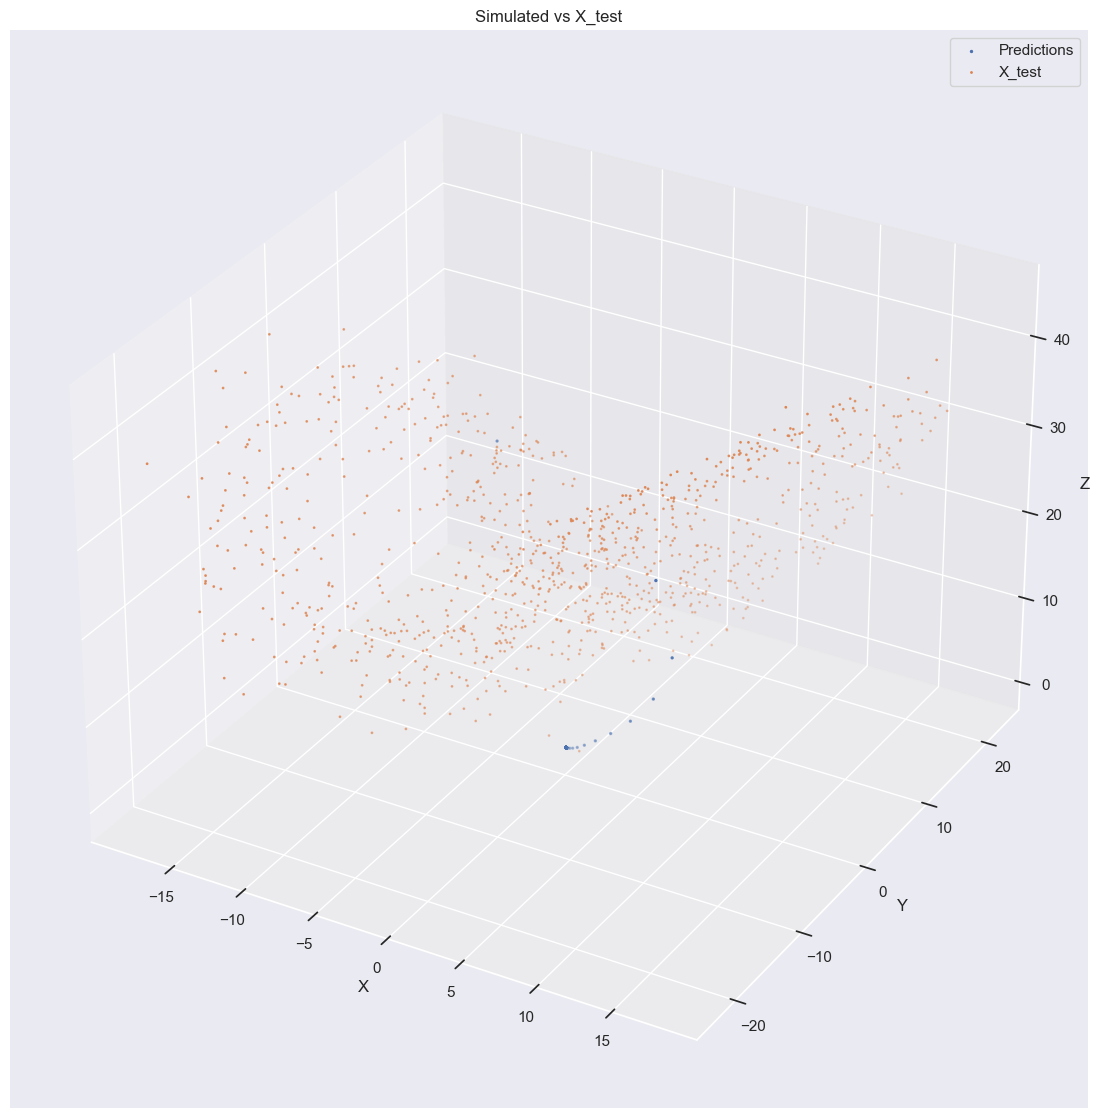

In [33]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = trajectories_np_extend[:, 0:, :, 0]
y_pred = trajectories_np_extend[:, 0:, :, 1]
z_pred = trajectories_np_extend[:, 0:, :, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train_data[:, 0].cpu()
y_train = train_data[  :, 1].cpu()
z_train = train_data[ :, 2].cpu()

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()



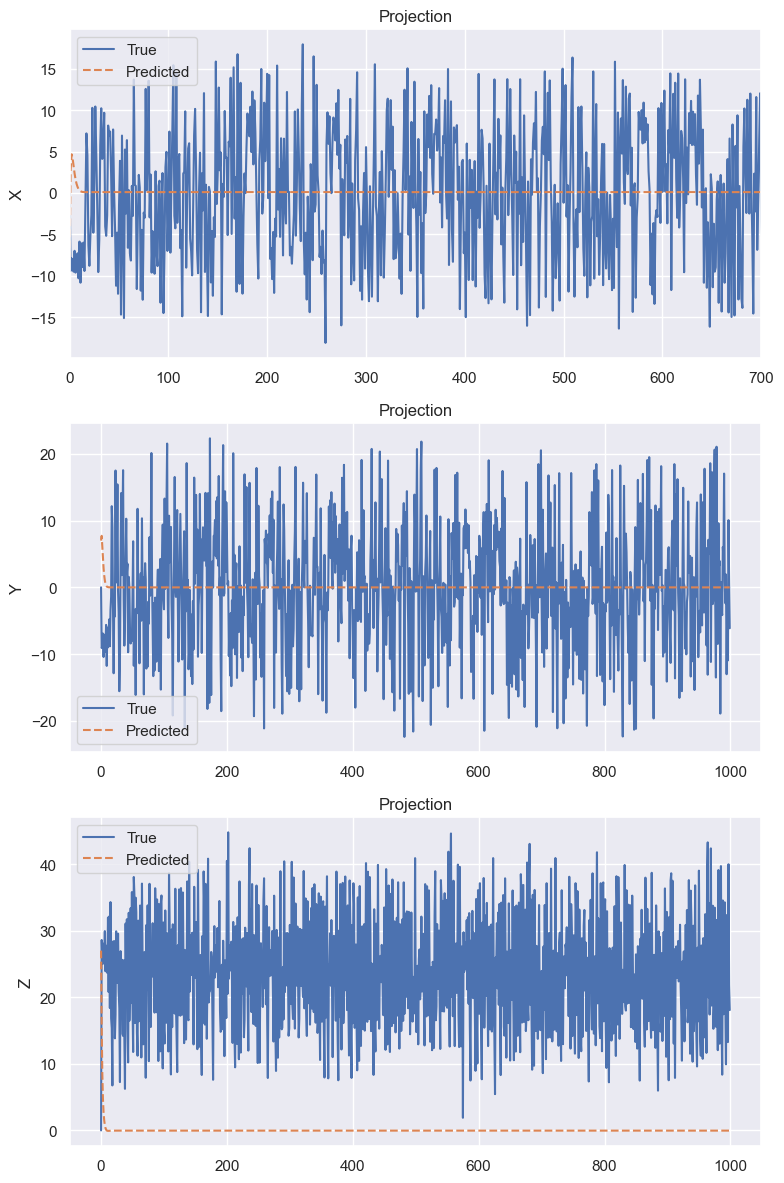

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred[0,:,0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
ax[0].set_xlim(0, 700)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred[0,:,0], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred[0,:,0], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

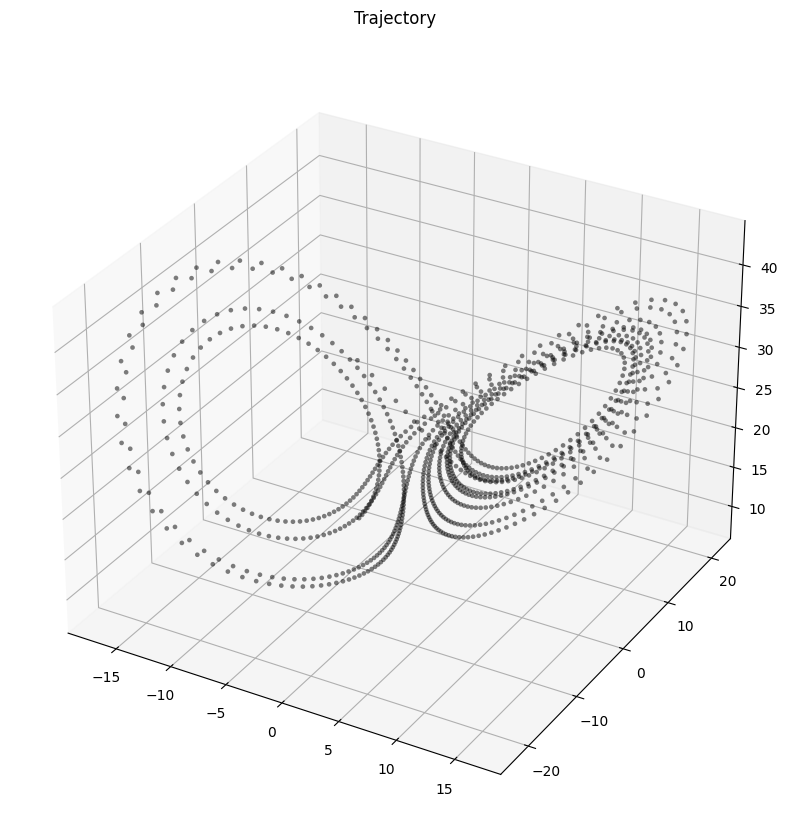

In [22]:
true_y0 = torch.tensor([[-8., 7., 27.]])  # initial condition
t = torch.linspace(0., 10., 1000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    true_lorenz = odeint(Lorenz(), true_y0, t)

visualize_3d(obs=true_lorenz)

In [12]:

model_lyap = LorenzTrain()  # initializing Neural ODE
visualizer = visualize_3d
optimizer = optim.Adam(model_lyap.parameters(), lr=1e-2)

In [15]:
train_data = true_lorenz

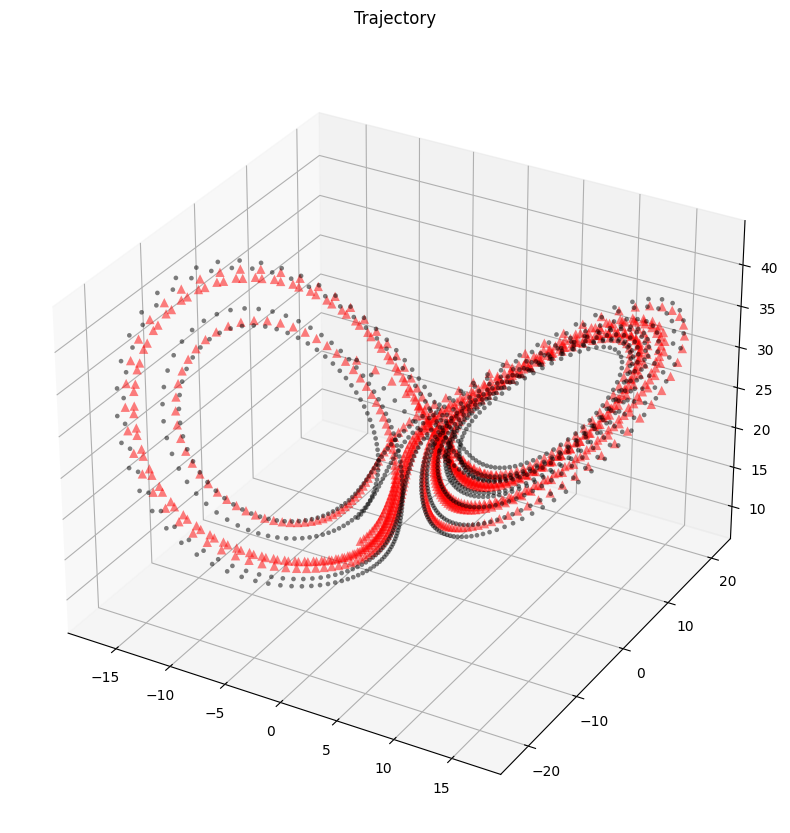

Iter 3000 | Total Loss 86.547752


In [17]:
for itr in range(1, wandb.config.max_iterations + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(train_data, wandb.config.batch_size)

    pred_y = odeint(model_lyap, batch_y0, batch_t)
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()

    if itr % 40 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(model_lyap, train_data[0], t)
            loss = F.mse_loss(pred_y, train_data)
            save_name = "PNG/" + str(itr)

            visualize_3d(obs=train_data, trajs=pred_y, save=save_name)

            # Log metrics to wandb
            wandb.log({'Iteration': itr, 'Loss': loss.item()})
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)

In [25]:
train_data[0].shape

torch.Size([1, 3])